In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('cybersecurity_intrusion_data.csv')
data.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [3]:
missing_values_rows = data.isnull().any(axis=1)
print(data[missing_values_rows])

     session_id  network_packet_size protocol_type  login_attempts  \
8     SID_00009                  406           TCP               2   
9     SID_00010                  608           UDP               6   
12    SID_00013                  548           TCP               2   
14    SID_00015                  155           TCP               3   
17    SID_00018                  562           UDP               1   
...         ...                  ...           ...             ...   
9516  SID_09517                  869           TCP               4   
9529  SID_09530                  469           TCP               1   
9530  SID_09531                  661           UDP               5   
9533  SID_09534                  380           TCP               3   
9536  SID_09537                  340           TCP               6   

      session_duration encryption_used  ip_reputation_score  failed_logins  \
8           542.558895             NaN             0.294580              0   
9  

In [4]:
duplicated_rows = data[data.duplicated()]
print(duplicated_rows)

Empty DataFrame
Columns: [session_id, network_packet_size, protocol_type, login_attempts, session_duration, encryption_used, ip_reputation_score, failed_logins, browser_type, unusual_time_access, attack_detected]
Index: []


In [5]:
data.dropna(axis=0, inplace=True)


In [6]:
data.drop_duplicates(inplace=True)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

               normal  intrusion
protocol_type                   
ICMP              234        161
TCP              2904       2331
UDP              1079        862


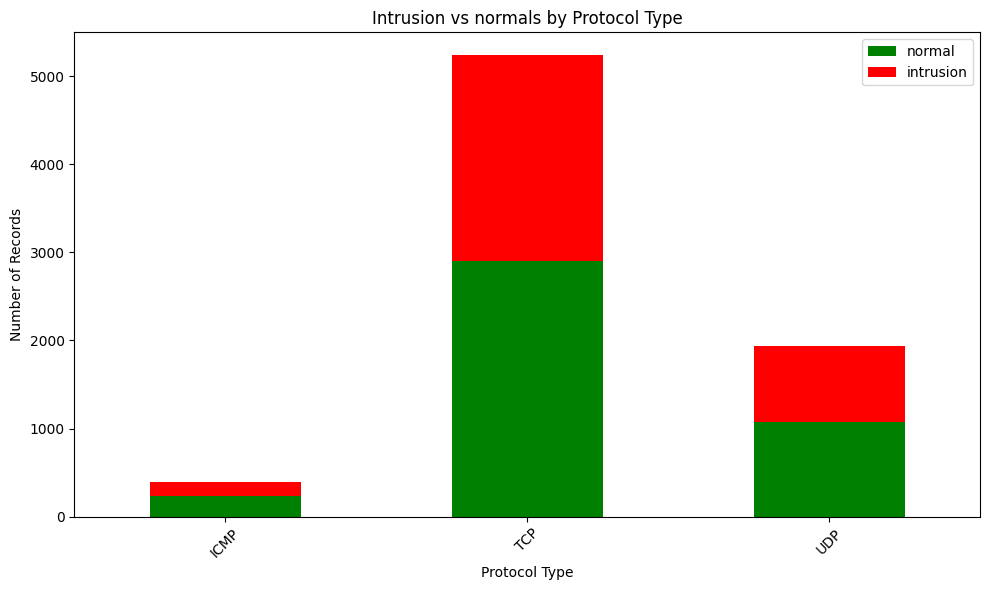

In [8]:
attack_counts = data.groupby('protocol_type')['attack_detected'].value_counts().unstack().fillna(0)
attack_counts.columns = ['normal', 'intrusion']
print(attack_counts)
attack_counts.plot(kind='bar', stacked=True, figsize=(10,6), color=['green', 'red'])
plt.title('Intrusion vs normals by Protocol Type')
plt.xlabel('Protocol Type')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

intrusion rates by browser type (%):

browser_type
Unknown    73.551637
Safari     43.455497
Edge       43.364328
Chrome     42.528172
Firefox    42.370661
Name: count, dtype: float64


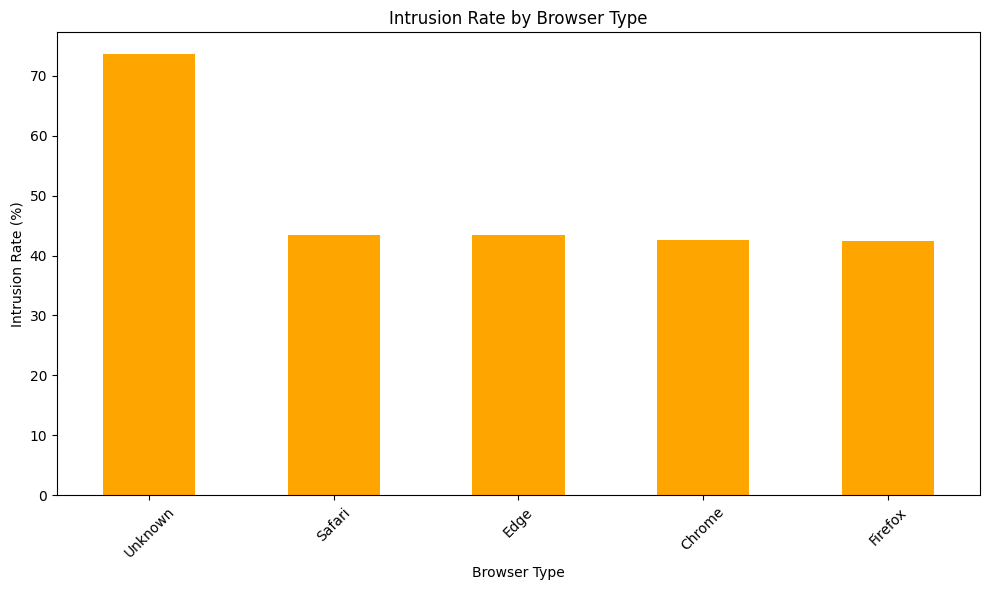

In [9]:
total_sessions = data['browser_type'].value_counts()
intrusions = data[data['attack_detected'] == 1]
intrusions_counts = intrusions['browser_type'].value_counts()
intrusion_rate  = (intrusions_counts / total_sessions * 100).sort_values(ascending=False)
print("intrusion rates by browser type (%):\n")
print(intrusion_rate)
plt.figure(figsize=(10,6))
intrusion_rate.plot(kind='bar', color='orange')
plt.title('Intrusion Rate by Browser Type')
plt.xlabel('Browser Type')
plt.ylabel('Intrusion Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
average_attempts = data.groupby('attack_detected')[['login_attempts', 'failed_logins']].mean()
average_attempts.index = ['normal', 'intrusion']
print("Average Login Attempts and Failed Logins:\n")
print(average_attempts)

Average Login Attempts and Failed Logins:

           login_attempts  failed_logins
normal           3.547309       1.183543
intrusion        4.641026       1.950507


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

random forest feature importances:

failed_logins          0.285881
ip_reputation_score    0.232863
login_attempts         0.214930
session_duration       0.098113
network_packet_size    0.088747
browser_type           0.049381
protocol_type          0.012458
unusual_time_access    0.008829
encryption_used        0.008798
dtype: float64


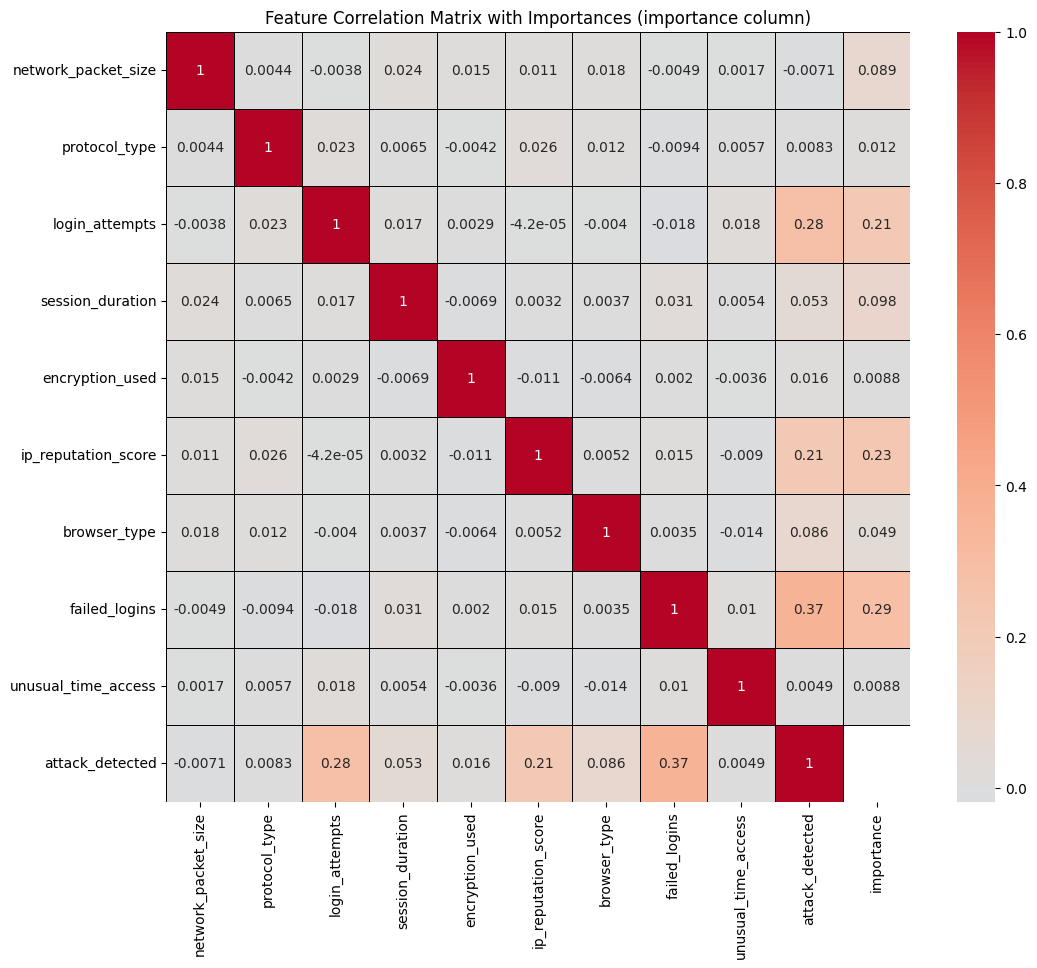

In [12]:
# encode categorical columns if they are non-numeric (LabelEncoder already imported)
for col in ['protocol_type', 'encryption_used', 'browser_type']:
    le = LabelEncoder()
    if data[col].dtype == 'object' or str(data[col].dtype).startswith('category'):
        data[col] = le.fit_transform(data[col])

# corrected feature names (fixed typos) and removed duplicate 'browser_type'
features = [
    'network_packet_size',
    'protocol_type',
    'login_attempts',
    'session_duration',        # corrected from 'sesion_duration'
    'encryption_used',
    'ip_reputation_score',
    'browser_type',
    'failed_logins',
    'unusual_time_access'      # corrected from 'unusal_time_access'
]

X = data[features]
y = data['attack_detected']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

feature_importances = model.feature_importances_
importances_series = pd.Series(feature_importances, index=features)
importances_sorted = importances_series.sort_values(ascending=False)
print('random forest feature importances:\n')
print(importances_sorted)

# correlation matrix for features + target
corr_matrix = data[features + ['attack_detected']].corr()

# add importances as a separate column aligned to the correlation matrix index
importances_df = corr_matrix.copy()
importances_df['importance'] = importances_series.reindex(importances_df.index)

plt.figure(figsize=(12,10))
sns.heatmap(importances_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='black')
plt.title('Feature Correlation Matrix with Importances (importance column)')
plt.show()

Successfully loaded 'cybersecurity_intrusion_data.csv'.
Data processed and split.
Training models...


c:\Users\VICTUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Models trained successfully.

Predictions generated.
--- Random Forest Classification Report ---
               precision    recall  f1-score   support

   Normal (0)       0.85      0.99      0.91       841
Intrusion (1)       0.99      0.78      0.87       674

     accuracy                           0.90      1515
    macro avg       0.92      0.89      0.89      1515
 weighted avg       0.91      0.90      0.89      1515


--- Logistic Regression Classification Report ---
               precision    recall  f1-score   support

   Normal (0)       0.75      0.78      0.76       841
Intrusion (1)       0.71      0.68      0.69       674

     accuracy                           0.73      1515
    macro avg       0.73      0.73      0.73      1515
 weighted avg       0.73      0.73      0.73      1515


--- Naive Bayes Classification Report ---
               precision    recall  f1-score   support

   Normal (0)       0.79      0.94      0.86       841
Intrusion (1)       0.91      0.

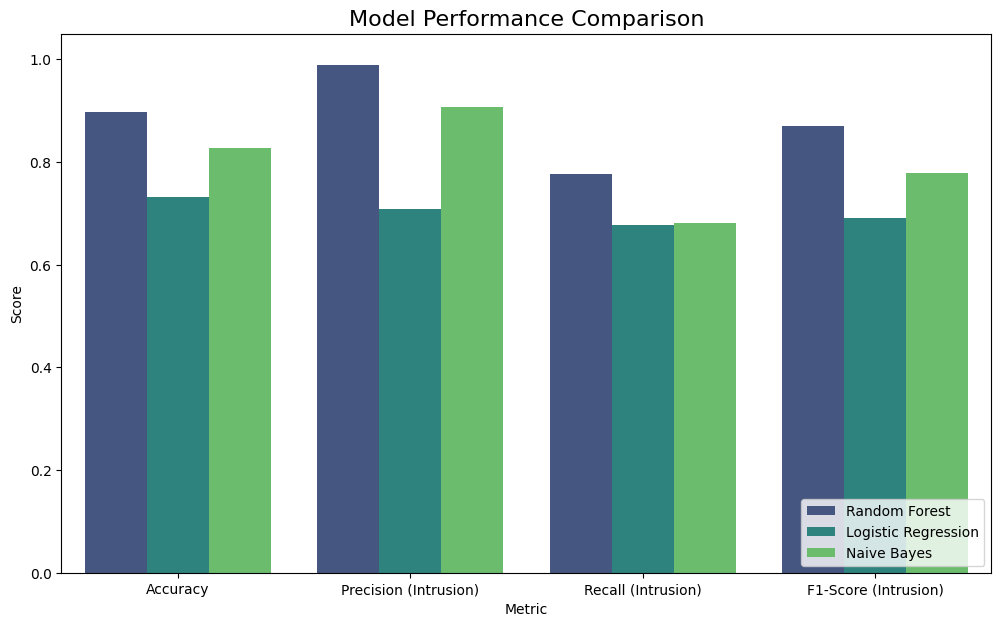

Created confusion_matrices.png


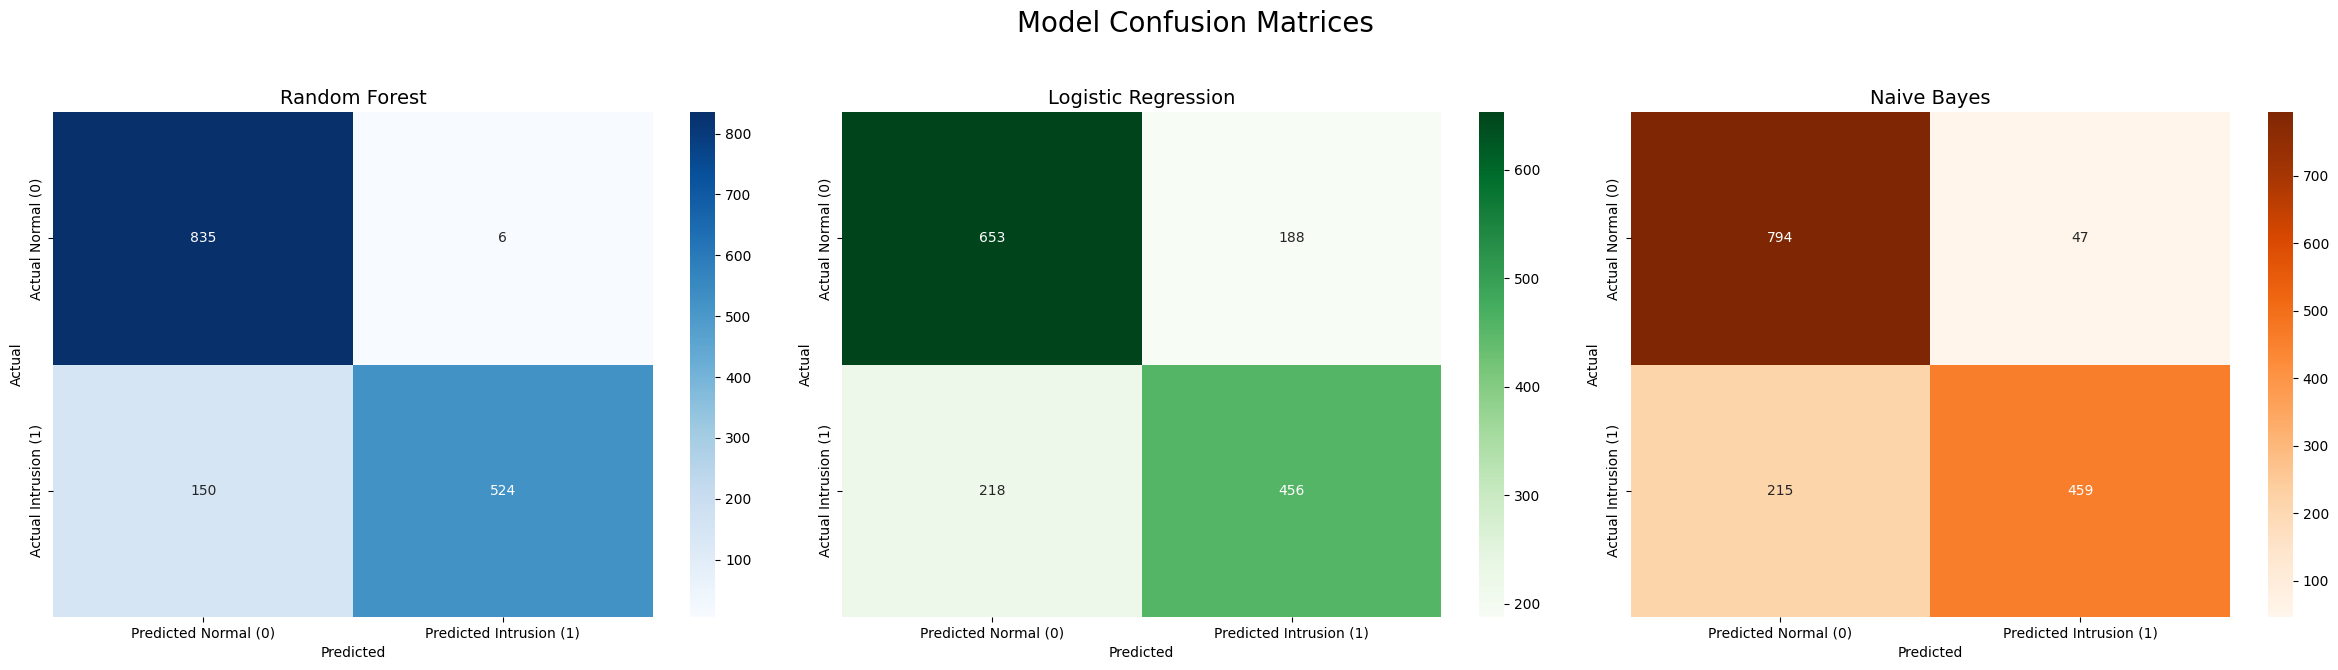

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB  # Import Naive Bayes
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

# --- 1. Load and Process Data ---
try:
    data = pd.read_csv('cybersecurity_intrusion_data.csv')
    print("Successfully loaded 'cybersecurity_intrusion_data.csv'.")
except FileNotFoundError:
    print("Error: 'cybersecurity_intrusion_data.csv' not found.")
    # In a real script, you might want to exit or raise an error here
    # For this example, we'll assume the file loads.
    
# Clean data
data.dropna(axis=0, inplace=True)
data.drop_duplicates(inplace=True)

# Define features and target
features = [
    'failed_logins', 'ip_reputation_score', 'login_attempts', 
    'session_duration', 'network_packet_size', 'browser_type', 'protocol_type'
]
target = 'attack_detected'

X = data[features]
y = data[target]

# One-Hot Encoding for categorical features
categorical_features = ['browser_type', 'protocol_type']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Transform categorical features
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_features]))
X_encoded.columns = encoder.get_feature_names_out(categorical_features)
X_encoded.index = X.index

# Combine numeric features with encoded categorical features
X_numeric = X.drop(columns=categorical_features)
X_processed = pd.concat([X_numeric, X_encoded], axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
print("Data processed and split.")

# --- 2. Train Models ---
print("Training models...")
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Naive Bayes (Gaussian)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
print("Models trained successfully.\n")

# --- 3. Get Predictions & Metrics ---
y_pred_rf = rf_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)
y_pred_nb = nb_model.predict(X_test)
print("Predictions generated.")

# Classification Reports (for your reference)
print("--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred_rf, target_names=['Normal (0)', 'Intrusion (1)']))

print("\n--- Logistic Regression Classification Report ---")
print(classification_report(y_test, y_pred_lr, target_names=['Normal (0)', 'Intrusion (1)']))

print("\n--- Naive Bayes Classification Report ---")
print(classification_report(y_test, y_pred_nb, target_names=['Normal (0)', 'Intrusion (1)']))

# Store metrics in a DataFrame for plotting
metrics_data = {
    'Model': ['Random Forest', 'Logistic Regression', 'Naive Bayes'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf), 
        accuracy_score(y_test, y_pred_lr), 
        accuracy_score(y_test, y_pred_nb)
    ],
    'Precision (Intrusion)': [
        precision_score(y_test, y_pred_rf), 
        precision_score(y_test, y_pred_lr), 
        precision_score(y_test, y_pred_nb)
    ],
    'Recall (Intrusion)': [
        recall_score(y_test, y_pred_rf), 
        recall_score(y_test, y_pred_lr), 
        recall_score(y_test, y_pred_nb)
    ],
    'F1-Score (Intrusion)': [
        f1_score(y_test, y_pred_rf), 
        f1_score(y_test, y_pred_lr), 
        f1_score(y_test, y_pred_nb)
    ]
}
df_metrics = pd.DataFrame(metrics_data)

# --- 4. Visualization 1: Metric Comparison Bar Chart ---
# Melt the DataFrame to long format for Seaborn
df_melted = df_metrics.melt('Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Score')
plt.ylim(0, 1.05) # Set y-axis limit to 1.05 for better visibility
plt.legend(loc='lower right')
plt.savefig("model_comparison_chart.png") # Save the chart
print("\nCreated model_comparison_chart.png")
plt.show() # Display the chart

# --- 5. Visualization 2: Confusion Matrices ---
# Get confusion matrices
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Model Confusion Matrices', fontsize=20) # Add a main title

# RF Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Predicted Normal (0)', 'Predicted Intrusion (1)'],
            yticklabels=['Actual Normal (0)', 'Actual Intrusion (1)'])
axes[0].set_title('Random Forest', fontsize=14)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# LR Confusion Matrix
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Predicted Normal (0)', 'Predicted Intrusion (1)'],
            yticklabels=['Actual Normal (0)', 'Actual Intrusion (1)'])
axes[1].set_title('Logistic Regression', fontsize=14)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# NB Confusion Matrix
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=['Predicted Normal (0)', 'Predicted Intrusion (1)'],
            yticklabels=['Actual Normal (0)', 'Actual Intrusion (1)'])
axes[2].set_title('Naive Bayes', fontsize=14)
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.savefig("confusion_matrices.png") # Save the chart
print("Created confusion_matrices.png")
plt.show() # Display the chart

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

features = ['failed_logins','ip_reputation_score','login_attempts','session_duration','network_packet_size','browser_type','protocol_type']
target = 'attack_detected'
X = data[features]
y = data[target]
categorical_features = ['browser_type','protocol_type']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_features]))
X_encoded.index = X.index
X = X.drop(columns=categorical_features)
X = pd.concat([X, X_encoded], axis=1)
X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier (n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

def predict_user_input():
  print("Enter session details to predict intrusion (1) or normal (0):")
  failed_logins = int(input("Failed logins: "))
  ip_reputation_score = float(input("Ip reputation score (0-1): "))
  login_attempts = int(input("Login attempts: "))
  session_duration = float(input("Session duration (seconds): "))
  network_packet_size = float(input("Network packet size (bytes): "))
  browser_type = input("Browser type (Edge/Firefox/Chrome/Safari/Unknown)")
  protocol_type = input("Protocol type (TCP/UDP/ICMP)")

  user_df = pd.DataFrame([[
      failed_logins, ip_reputation_score, login_attempts, session_duration, network_packet_size, browser_type, protocol_type
  ]], columns=features)
  user_encoded = pd.DataFrame(encoder.transform(user_df[categorical_features]))
  user_encoded.index = user_df.index
  user_df = user_df.drop(columns=categorical_features)
  user_df = pd.concat([user_df, user_encoded], axis=1)
  user_df.columns = user_df.columns.astype(str)
  prediction = rf.predict(user_df)[0]
  if prediction == 1:
    print("Prediction: Intrusion detected!")
  else:
    print("Prediction: Normal or safe session")



In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [17]:
features = ['failed_logins','ip_reputation_score','login_attempts','session_duration','network_packet_size','browser_type','protocol_type']
target = 'attack_detected'
X = data[features]
y = data[target]
categorical_features = ['browser_type','protocol_type']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_features]))
X_encoded.index = X.index
X = X.drop(columns=categorical_features)
X = pd.concat([X, X_encoded], axis=1)
X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

def predict_user_input():
  print("Enter session details to predict intrusion (1) or normal (0):")
  failed_logins = int(input("Failed logins: "))
  ip_reputation_score = float(input("Ip reputation score (0-1): "))
  login_attempts = int(input("Login attempts: "))
  session_duration = float(input("Session duration (seconds): "))
  network_packet_size = float(input("Network packet size (bytes): "))
  browser_type = input("Browser type (Edge/Firefox/Chrome/Safari/Unknown)")
  protocol_type = input("Protocol type (TCP/UDP/ICMP)")

  user_df = pd.DataFrame([[
      failed_logins, ip_reputation_score, login_attempts, session_duration, network_packet_size, browser_type, protocol_type
  ]], columns=features)
  user_encoded = pd.DataFrame(encoder.transform(user_df[categorical_features]))
  user_encoded.index = user_df.index
  user_df = user_df.drop(columns=categorical_features)
  user_df = pd.concat([user_df, user_encoded], axis=1)
  user_df.columns = user_df.columns.astype(str)
  prediction = lr_model.predict(user_df)[0]
  probability = lr_model.predict_proba(user_df)[0][1]
  if prediction == 1:
    print(f"Prediction: Intrusion detected! (Probability: {probability:.2f})")
  else:
    print(f"Prediction: Normal or safe session (Probability: {probability:.2f})")

predict_user_input()

Enter session details to predict intrusion (1) or normal (0):


c:\Users\VICTUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: invalid literal for int() with base 10: ''